In [ ]:
!pip install transformers datasets evaluate seqeval sklearn_crfsuite

In [156]:
import pandas as pd
import numpy as np
import evaluate
import requests
import pytest
import time
from collections import Counter, defaultdict
from sklearn import metrics
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import sklearn
import sklearn_crfsuite
from sklearn.metrics import classification_report
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics as crf_metrics

import torch
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional, Union
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments, 
    Trainer,
)

In [157]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


# Loading data and preprocessing

In [158]:
train_txt = requests.get('https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/token_classification/train.txt').text
val_txt   = requests.get('https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/token_classification/dev.txt')  .text
test_txt  = requests.get('https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/token_classification/test.txt') .text

In [159]:
def text_preproc(text: str) -> pd.DataFrame:
    '''
    preprocessing input texts 
    '''
    splitted_text = text.split('\n')
    sentences, tags = [], []
    sentence, tag = [], []
    
    for text in splitted_text:

        if text != '':
            text = text.split(' ')
            sentence.append(text[0])
            tag.append(text[1])
        else:
            sentences.append(sentence)
            tags.append(tag)
            sentence, tag = [], []
    
    df = pd.DataFrame({'Text': sentences,
                       'Labels': tags})

    return df

In [160]:
train_data = text_preproc(train_txt)
print(train_data.shape)
train_data.head()

(7747, 2)


,Text,Labels
0,"["", Если, Миронов, занял, столь, оппозиционную...","[O, O, B-PER, O, O, O, O, O, O, O, O, O, O, O,..."
1,"[Источник, "", Ъ, '', в, руководстве, столичной...","[O, O, B-ORG, O, O, O, O, O, O, O, O, O, O, B-..."
2,"[В, Ханты-Мансийском, автономном, округе, с, д...","[O, B-LOC, I-LOC, I-LOC, O, O, O, O, B-ORG, B-..."
3,"[С, 1992, года, по, настоящее, время, является...","[O, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, ..."
4,"[Для, этого, ей, пришлось, выиграть, выборы, в...","[O, O, O, O, O, O, O, O, O, O, B-LOC, I-LOC, O..."


In [161]:
val_data = text_preproc(val_txt)
print(val_data.shape)
val_data.head()

(2583, 2)


,Text,Labels
0,"[как, акционерный, коммерческий, Московский, м...","[O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I..."
1,"[Управлять, ЦАО, и, САО, вместо, Алексея, Алек...","[O, B-LOC, O, B-LOC, O, B-PER, I-PER, O, B-PER..."
2,"[О, задержании, Шакирьянова, стало, известно, ...","[O, O, B-PER, O, O, O, O, O, O, O]"
3,"[После, майского, ухода, вице-премьера, Владис...","[O, O, O, O, B-PER, I-PER, O, O, O, O, O, B-PE..."
4,"[Армяне, со, мной, согласились, ,, с, Ильхамом...","[O, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O..."


In [162]:
test_data = text_preproc(test_txt)
print(test_data.shape)
test_data.head()

(2583, 2)


,Text,Labels
0,"[Тогда, замешанные, в, скандале, прокуроры, от...","[O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[Символичным, назвал, председатель, РФМ, ,, де...","[O, O, O, B-ORG, O, O, B-ORG, I-ORG, B-LOC, B-..."
2,"[На, посту, гендиректора, Yahoo, !, B-ORG, Кэр...","[O, O, O, O, O, O, B-PER, I-PER, O, B-PER, I-P..."
3,"[Считаю, невозможным, руководить, областью, с,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[Боксер, победила, Карли, Фиорину, (, Carly, F...","[B-PER, O, B-PER, I-PER, O, I-PER, O, O, O, O,..."


In [163]:
ner_tags = []
for labels_list in train_data['Labels']:
    for label in labels_list:
        ner_tags.append(label)
ner_tags = list(set(ner_tags))
print(ner_tags)

['I-LOC', 'B-ORG', 'B-PER', 'B-LOC', 'O', 'I-PER', 'I-ORG']


In [164]:
# creating а mapping in this order of labels (the order will come in handy in the future)
label2id = dict(zip(['O', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER'], list(range(7))))
print(label2id)

id2label = {v: k for k, v in label2id.items()}
print(id2label)

{'O': 0, 'B-LOC': 1, 'I-LOC': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-PER': 5, 'I-PER': 6}
{0: 'O', 1: 'B-LOC', 2: 'I-LOC', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-PER', 6: 'I-PER'}


In [165]:
def_dict_counter = defaultdict(int)

for tags in train_data['Labels']:
  for tag in tags:
    def_dict_counter[tag] += 1

def_dict_counter

defaultdict(int,
            {'O': 132788,
             'B-PER': 6359,
             'B-ORG': 5084,
             'I-ORG': 3227,
             'B-LOC': 4335,
             'I-LOC': 972,
             'I-PER': 3925})

As we see, we have dominating number of class 'O'. Our main goal is to make such model, that will not overfit to predict always O token.

We will use f1-score and then estimate classification_report after excluding the class 'O'.

# Model 1: Sklearn CRF (Conditional Random Fields)

## Additional preprocessing

In [ ]:
def label_encode(labels):
    new_labels = []
    for label in labels:
        new_labels.append(label2id[label])
    return new_labels

train_data['Labels'] = train_data['Labels'].apply(label_encode)
val_data['Labels']   = val_data['Labels']  .apply(label_encode)
test_data['Labels']  = test_data ['Labels'].apply(label_encode)

train_data.head()

,Text,Labels
0,"["", Если, Миронов, занял, столь, оппозиционную...","[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Источник, "", Ъ, '', в, руководстве, столичной...","[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, ..."
2,"[В, Ханты-Мансийском, автономном, округе, с, д...","[0, 1, 2, 2, 0, 0, 0, 0, 3, 5, 6, 0]"
3,"[С, 1992, года, по, настоящее, время, является...","[0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 4, 0, 0, ..."
4,"[Для, этого, ей, пришлось, выиграть, выборы, в...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0]"


As all sklearn-like libraries we need to get pandas.DataFrame as an input for this model. Let's create it.

In our DataFrame we will make each word, entity and sentence_id on each row:

sentense_id - which mark each word belonging to each sentence;
data - contains words on each row;
entities - marks which entity does each word refer to.

In [ ]:
train_crf_data = pd.DataFrame({
    'sent_id':  [i for j in [[i] * len(s) for i, s in enumerate(train_data['Text'])] for i in j],
    'data':     [i for j in train_data['Text'] for i in j],
    'entities': [id2label[i] for j in train_data['Labels'] for i in j],
})
train_crf_data.head()

,sent_id,data,entities
0,0,"""",O
1,0,Если,O
2,0,Миронов,B-PER
3,0,занял,O
4,0,столь,O


In [ ]:
val_crf_data = pd.DataFrame({
    'sent_id':  [i for j in [[i] * len(s) for i, s in enumerate(val_data['Text'])] for i in j],
    'data':     [i for j in val_data['Text'] for i in j],
    'entities': [id2label[i] for j in val_data['Labels'] for i in j],
})
val_crf_data.head()

,sent_id,data,entities
0,0,как,O
1,0,акционерный,O
2,0,коммерческий,O
3,0,Московский,B-ORG
4,0,муниципальный,I-ORG


In [ ]:
test_crf_data = pd.DataFrame({
    'sent_id':  [i for j in [[i] * len(s) for i, s in enumerate(test_data['Text'])] for i in j],
    'data':     [i for j in test_data['Text'] for i in j],
    'entities': [id2label[i] for j in test_data['Labels'] for i in j],
})
test_crf_data.head()

,sent_id,data,entities
0,0,Тогда,O
1,0,замешанные,O
2,0,в,O
3,0,скандале,O
4,0,прокуроры,O


In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['data'].values.tolist(), 
                                                     s['entities'].values.tolist())]
        self.grouped = self.data.groupby('sent_id').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None
     

In [ ]:
train_getter = SentenceGetter(train_crf_data)
val_getter   = SentenceGetter(val_crf_data)
test_getter  = SentenceGetter(test_crf_data)

train_getter.sentences[2]

[('В', 'O'),
 ('Ханты-Мансийском', 'B-LOC'),
 ('автономном', 'I-LOC'),
 ('округе', 'I-LOC'),
 ('с', 'O'),
 ('должности', 'O'),
 ('снят', 'O'),
 ('начальник', 'O'),
 ('УВД', 'B-ORG'),
 ('Николай', 'B-PER'),
 ('Гудожников', 'I-PER'),
 ('.', 'O')]

In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]
     

In [ ]:
X_train = [sent2features(s) for s in train_getter.sentences]
y_train = [sent2labels(s) for s in train_getter.sentences]
print(f'Length train: {len(X_train)}')

X_val   = [sent2features(s) for s in val_getter.sentences]
y_val   = [sent2labels(s) for s in val_getter.sentences]
print(f'Length valid: {len(X_val)}')

X_test  = [sent2features(s) for s in test_getter.sentences]
y_test  = [sent2labels(s) for s in test_getter.sentences]
print(f'Length test: {len(X_test)}')

Length train: 7746
Length valid: 2582
Length test: 2582


## Training and evaluating

In [ ]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)

# if we start the learning process, the training will be completed
# successfully, but the next error will appear:
# AttributeError: 'CRF' object has no attribute 'keep_tempfiles'
# https://stackoverflow.com/questions/66059532/attributeerror-crf-object-has-no-attribute-keep-tempfiles

try:
    crf.fit(X_train, y_train, X_val, y_val)
except AttributeError:
    pass

loading training data to CRFsuite: 100%|██████████| 7746/7746 [00:00<00:00, 8273.09it/s]


loading dev data to CRFsuite: 100%|██████████| 2582/2582 [00:00<00:00, 8689.08it/s]



Holdout group: 2

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 94630
Seconds required: 0.211

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.11  loss=157904.52 active=94282 precision=0.121  recall=0.143  F1=0.131  Acc(item/seq)=0.845 0.246  feature_norm=1.00
Iter 2   time=0.07  loss=156786.63 active=92364 precision=0.121  recall=0.143  F1=0.131  Acc(item/seq)=0.845 0.246  feature_norm=3.54
Iter 3   time=0.07  loss=122095.20 active=91424 precision=0.121  recall=0.143  F1=0.131  Acc(item/seq)=0.845 0.246  feature_norm=2.92
Iter 4   time=0.24  loss=87087.62 active=92329 precision=0.121  recall=0.143  F1=0.131  Acc(item/seq)=0.845 0.246  feature_norm=2.35
Iter 5   time=0.07  loss=80080.08 active=93620

In [ ]:
list(label2id.keys())

['O', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']

In [ ]:
all_entities = list(label2id.keys())
print(f'all_entities: {all_entities}')

y_pred = crf.predict(X_test)
crf_metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=all_entities)

all_entities: ['O', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']


0.9786359118090925

But our classes are disbalanced. 

Printing a classification report for all useful tokens (exluding token 'O').

In [ ]:
# classification_report from sklearn.metrics doesn't support sequence of
# secuences, so first we transform our data into one sequence
y_pred_flatten = [l for s in y_pred for l in s]
y_test_flatten = [l for s in y_test for l in s]

In [ ]:
print(metrics.classification_report(y_test_flatten, y_pred_flatten, labels=all_entities[1:]))

              precision    recall  f1-score   support

       B-LOC       0.93      0.93      0.93      1508
       I-LOC       0.95      0.92      0.93       342
       B-ORG       0.92      0.87      0.89      1734
       I-ORG       0.85      0.74      0.79      1090
       B-PER       0.92      0.94      0.93      2150
       I-PER       0.94      0.97      0.95      1367

   micro avg       0.92      0.90      0.91      8191
   macro avg       0.92      0.89      0.91      8191
weighted avg       0.92      0.90      0.91      8191



As we see, our results after excluding useless label 'O' are fallen.

# Model 2: based on RNN

In [166]:
label2id['<PAD>'] = 7
id2label[7] = '<PAD>'
label2id['<UNK>'] = 8
id2label[8] = '<UNK>'
print(label2id)
print()
print(id2label)

{'O': 0, 'B-LOC': 1, 'I-LOC': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-PER': 5, 'I-PER': 6, '<PAD>': 7, '<UNK>': 8}

{0: 'O', 1: 'B-LOC', 2: 'I-LOC', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-PER', 6: 'I-PER', 7: '<PAD>', 8: '<UNK>'}


In [167]:
def get_word_to_idx(count: List[Tuple[str, int]],
                   min_words: Union[int, float] = 0.0,
                   max_words: Union[int, float] = 1.0) -> Dict[str, int]:
    max_count = count[0][1]
    if isinstance(min_words, float):
        min_words = max_count * min_words
    if isinstance(max_words, float):
        max_words = max_count * max_words
    
    all_words = [w[0] for w in count if max_words >= w[1] >= min_words]
    
    all_words = ['<PAD>', '<UNK>'] + all_words
    
    word_to_idx = {k: v for k, v in zip(all_words, range(0, len(all_words)))}
    return word_to_idx

In [168]:
all_texts = [word for text in train_data['Text'] for word in text]
word_occurences = Counter(all_texts)
sorted_word_occur = [(k, v) for k, v in sorted(dict(word_occurences).items(), key=lambda item: -item[1])]
print(sorted_word_occur[:10])

[(',', 9538), ('.', 7701), ('в', 5169), ('и', 2529), ("''", 2202), ('"', 2186), ('на', 1941), ('с', 1317), ('что', 1302), ('по', 1187)]


In [169]:
word_to_idx = get_word_to_idx(sorted_word_occur)

In [170]:
def create_matrix_of_texts(dataset, max_sequence_length, 
                           pad_token, word2index, unk_token):
    texts = np.full((len(dataset), max_sequence_length),
                    word2index[pad_token], dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row))
          text = row[:trim_length]
          texts[ind, :trim_length] = [word2index.get(item.lower(),
                                                     word2index[unk_token]) for item in text]
    return texts

def create_matrix_of_tags(dataset, max_sequence_length, pad_index, tag2idx):
    tags = np.full((len(dataset), max_sequence_length),
                    pad_index, dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row))
          labels = row[: trim_length]
          tags[ind, : trim_length] = [tag2idx[item] for item in labels]
    return tags

count    7747.000000
mean       20.225894
std        11.158730
min         0.000000
25%        12.000000
50%        18.000000
75%        26.000000
max       103.000000
dtype: float64

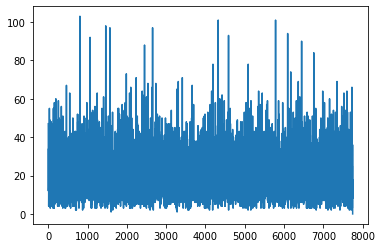

In [171]:
max_lens = list()
for row in train_data['Text']:
    max_lens.append(len(row))
max_lens = pd.Series(max_lens)
max_lens.plot();
max_lens.describe()

In [172]:
max_lens.quantile(0.97)

45.0

In [173]:
train_texts = create_matrix_of_texts(train_data['Text'], 
                               int(max_lens.quantile(0.97)),
                               '<PAD>', word_to_idx, '<UNK>')
train_tags = create_matrix_of_tags(train_data['Labels'],
                             int(max_lens.quantile(0.97)),
                             label2id['<PAD>'],
                             label2id)

val_texts = create_matrix_of_texts(val_data['Text'], 
                               int(max_lens.quantile(0.97)),
                               '<PAD>', word_to_idx, '<UNK>')
val_tags = create_matrix_of_tags(val_data['Labels'],
                             int(max_lens.quantile(0.97)),
                             label2id['<PAD>'],
                             label2id)

test_texts = create_matrix_of_texts(test_data['Text'], 
                               int(max_lens.quantile(0.97)),
                               '<PAD>', word_to_idx, '<UNK>')
test_tags = create_matrix_of_tags(test_data['Labels'],
                             int(max_lens.quantile(0.97)),
                             label2id['<PAD>'],
                             label2id)

In [400]:
class NerDataset(Dataset):
    def __init__(self,
                 texts: np.array,
                 tags:  np.array):
        self.tags = tags
        self.texts = texts
        

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens_tensor = torch.tensor(self.texts[idx], dtype=torch.int64)
        labels_tensor = torch.tensor(self.tags[idx], dtype=torch.int64)
        return tokens_tensor, labels_tensor

    def __len__(self) -> int:
        dataset_len = self.texts.shape[0]
        return dataset_len

In [401]:
train_dataset = NerDataset(train_texts, train_tags)
val_dataset = NerDataset(val_texts, val_tags)
test_dataset = NerDataset(test_texts, test_tags)

In [402]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [403]:
class NerRNNModel(nn.Module):
    def __init__(
        self,
        word2idx: Dict,
        embedding_dim: int = 100,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256
    ):
        super(NerRNNModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')
        self.word2idx = word2idx
        self.labels = mapping
        self.embedding = nn.Embedding(len(word_to_idx), embedding_dim)
        self.encoder = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
        )
        self.projection = nn.Linear(2*hidden_size, len(mapping))

    def forward(self, tokens: LongTensor) -> FloatTensor:

        emb = self.embedding(tokens)        
        h, _ = self.encoder(emb)
        pred = self.projection(h)
        return pred.view(-1, len(self.labels))

In [404]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in id2label.values() if value != 'O' and value != '<PAD>' and value != '<UNK>']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               int(max_lens.quantile(0.97)),
                                                               len(label2id)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    
    true_labels = [id2label[val] for val in true_labels]
    
    predicted = [id2label[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

In [405]:
model = NerRNNModel(word_to_idx, 300, label2id)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [406]:
sum([params.numel() for params in model.parameters() if params.requires_grad])

8337213

In [407]:
for e in range(6):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
        
    for sent in tqdm(train_dataloader):
            # sent = train_dataloader[i]
            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model.zero_grad()
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent
                
            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != 0
                # (4) Compute loss and do backward step
                loss = loss_function(pred_scores.to(device), gold_tags.view(-1).to(device))
                loss.backward()
                
                # (5) Optimize parameter values
                optimizer.step()
            
                # (6) Accumulate loss
                total_loss += loss
            

    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
    evaluate(val_dataloader)

  0%|          | 0/242 [00:00<?, ?it/s]

TypeError: ignored

In [319]:
train_dataset[0]

tensor([    7,   218,     1,   370,  2827,  7274,  1059,     2,    95,  1060,
         3337,     2,    10,    39,   268,    68,   196, 11518,     5, 11519,
          524,     4,    44,     9,  7275,   511,   160,     2,   160,     2,
           51, 11520,   180,   164,     7,  4762,     1,     6,     5, 11521,
          525,     6,     2,    12,  7276,     0,     0,     5,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            3,     4,     0,     0,     0,     0,     0,     0,     0,     0])

# Model 3: Fine-tuning HuggingFace pretrained LaBSE model (BERT architecture)

https://huggingface.co/surdan/LaBSE_ner_nerel

## Additional preprocessing

In [ ]:
def label_encode(labels):
    new_labels = []
    for label in labels:
        new_labels.append(label2id[label])
    return new_labels

train_data['Labels'] = train_data['Labels'].apply(label_encode)
val_data['Labels']   = val_data['Labels']  .apply(label_encode)
test_data['Labels']  = test_data ['Labels'].apply(label_encode)

train_data.head()

,Text,Labels
0,"["", Если, Миронов, занял, столь, оппозиционную...","[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Источник, "", Ъ, '', в, руководстве, столичной...","[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, ..."
2,"[В, Ханты-Мансийском, автономном, округе, с, д...","[0, 1, 2, 2, 0, 0, 0, 0, 3, 5, 6, 0]"
3,"[С, 1992, года, по, настоящее, время, является...","[0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 4, 0, 0, ..."
4,"[Для, этого, ей, пришлось, выиграть, выборы, в...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0]"


In [ ]:
hg_train = Dataset.from_pandas(train_data)
assert hg_train.shape == train_data.shape
print(f'Train shape: {hg_train.shape}')

hg_val = Dataset.from_pandas(val_data)
assert hg_val.shape == val_data.shape
print(f'Valid shape: {hg_val.shape}')

hg_test = Dataset.from_pandas(test_data)
assert hg_test.shape == test_data.shape
print(f'Test shape: {hg_test.shape}')

print(hg_train)
print(hg_val)
print(hg_test)

Train shape: (7747, 2)
Valid shape: (2583, 2)
Test shape: (2583, 2)
Dataset({
    features: ['Text', 'Labels'],
    num_rows: 7747
})
Dataset({
    features: ['Text', 'Labels'],
    num_rows: 2583
})
Dataset({
    features: ['Text', 'Labels'],
    num_rows: 2583
})


In [ ]:
# model_checkpoint = 'surdan/LaBSE_ner_nerel'
model_checkpoint = './LaBSE_ner_nerel'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer.is_fast

True

In [ ]:
inputs = tokenizer(hg_train['Text'][0], is_split_into_words=True)
print(inputs.tokens())

['[CLS]', '"', 'Если', 'Мир', '##онов', 'занял', 'столь', 'оп', '##по', '##зици', '##он', '##ную', 'позицию', ',', 'то', 'мне', 'представляется', ',', 'что', 'для', 'него', 'было', 'бы', 'поряд', '##очным', 'и', 'правил', '##ьным', 'уйти', 'в', 'отставку', 'с', 'зани', '##ма', '##емого', 'им', 'поста', ',', 'поста', ',', 'который', 'пред', '##оста', '##влен', 'ему', 'сегодня', '"', 'Единой', 'Россией', "'", "'", 'и', 'ник', '##ем', 'больше', "'", "'", ',', '-', 'за', '##кл', '##юча', '##ет', 'Иса', '##ев', '.', '[SEP]']


In [ ]:
print(inputs.word_ids())

[None, 0, 1, 2, 2, 3, 4, 5, 5, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 18, 19, 19, 20, 21, 22, 23, 24, 24, 24, 25, 26, 27, 28, 29, 30, 31, 31, 31, 32, 33, 34, 35, 36, 37, 37, 38, 39, 39, 40, 41, 41, 42, 43, 44, 44, 44, 44, 45, 45, 46, None]


In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as precious token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [ ]:
labels = hg_train['Labels'][0]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
[-100, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, -100]


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['Text'], truncation=True, is_split_into_words=True
    )
    all_labels = examples['Labels']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_train = hg_train.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=hg_train.column_names
)

tokenized_val = hg_val.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=hg_val.column_names
)

tokenized_test = hg_test.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=hg_test.column_names
)

print(tokenized_train)
print(tokenized_val)
print(tokenized_test)

Map:   0%|          | 0/7747 [00:00<?, ? examples/s]

Map:   0%|          | 0/2583 [00:00<?, ? examples/s]

Map:   0%|          | 0/2583 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 7747
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 2583
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 2583
})


In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
batch = data_collator([tokenized_train[i] for i in range(2)])
batch['labels']

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    5,    6,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    3,
            4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    5,    6,    0, -100],
        [-100,    0,    0,    3,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    5,
            6,    6,    0,    0,    0,    0,    0,    0,    0,    0,    1,    2,
            0,    0,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100]])

In [ ]:
metric = evaluate.load('seqeval')

In [ ]:
labels = train_data['Labels'][0]
labels = [id2label[i] for i in labels]
print(labels)

['O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O']


In [ ]:
fake_predictions = labels.copy()
fake_predictions[2] = 'O'
metric.compute(predictions=[fake_predictions], references=[labels])

{'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'PER': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.9787234042553191}

## Training and evaluating

In [ ]:
def compute_metric(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': all_metrics['overall_precision'],
        'recall'   : all_metrics['overall_recall'],
        'f1'       : all_metrics['overall_f1'],
        'accuracy' : all_metrics['overall_accuracy'],
    }

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ./LaBSE_ner_nerel and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([58, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([58]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    model_checkpoint,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    # per_device_train_batch_size=2,
    # per_device_eval_batch_size=2,
    # per_gpu_train_batch_size=8
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    compute_metrics=compute_metric,
    tokenizer=tokenizer,
)

trainer.train()

C:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7747
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2907
  Number of trainable parameters = 127759879


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.089100,0.035708,0.962553,0.966616,0.964580,0.991950
2,0.018300,0.028382,0.972896,0.977936,0.975409,0.993894
3,0.006400,0.026965,0.971957,0.977552,0.974747,0.994646


***** Running Evaluation *****
  Num examples = 2583
  Batch size = 8
Saving model checkpoint to ./LaBSE_ner_nerel\checkpoint-969
Configuration saved in ./LaBSE_ner_nerel\checkpoint-969\config.json
Model weights saved in ./LaBSE_ner_nerel\checkpoint-969\pytorch_model.bin
tokenizer config file saved in ./LaBSE_ner_nerel\checkpoint-969\tokenizer_config.json
Special tokens file saved in ./LaBSE_ner_nerel\checkpoint-969\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2583
  Batch size = 8
Saving model checkpoint to ./LaBSE_ner_nerel\checkpoint-1938
Configuration saved in ./LaBSE_ner_nerel\checkpoint-1938\config.json
Model weights saved in ./LaBSE_ner_nerel\checkpoint-1938\pytorch_model.bin
tokenizer config file saved in ./LaBSE_ner_nerel\checkpoint-1938\tokenizer_config.json
Special tokens file saved in ./LaBSE_ner_nerel\checkpoint-1938\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2583
  Batch size = 8
Saving model checkpoint to ./LaBSE_ne

TrainOutput(global_step=2907, training_loss=0.029457506544613783, metrics={'train_runtime': 336.9097, 'train_samples_per_second': 68.983, 'train_steps_per_second': 8.628, 'total_flos': 723405212214564.0, 'train_loss': 0.029457506544613783, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(tokenized_test)

***** Running Prediction *****
  Num examples = 2583
  Batch size = 8


In [ ]:
tokenized_test

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 2583
})

In [ ]:
(predictions[2])

{'test_loss': 0.02278028428554535,
 'test_precision': 0.97513160283173,
 'test_recall': 0.979219832300401,
 'test_f1': 0.9771714415643474,
 'test_accuracy': 0.9952530654676169,
 'test_runtime': 7.3641,
 'test_samples_per_second': 350.755,
 'test_steps_per_second': 43.861}

In [ ]:
predictions[0].shape

(2583, 368, 7)

In [ ]:
labels_true = [l for s in tokenized_test['labels'] for l in s+[-100]*(predictions[0].shape[1] - len(s))]
labels_true = [0 if l==-100 else l for l in labels_true]
print(len(labels_true))

labels_pred = [np.argmax(l) for s in predictions[0] for l in s]

assert len(labels_true)==len(labels_pred)

950544


In [ ]:
print(f'labels_true: {Counter(labels_true)}')
print(f'labels_pred: {Counter(labels_pred)}')

labels_true: Counter({0: 933118, 6: 6501, 4: 3735, 5: 2150, 2: 1798, 3: 1734, 1: 1508})
labels_pred: Counter({0: 932652, 6: 6785, 4: 3859, 5: 2159, 2: 1831, 3: 1746, 1: 1512})


In [ ]:
print(metrics.classification_report(labels_true, labels_pred, labels=list(id2label.keys())[1:]))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      1508
           2       0.96      0.98      0.97      1798
           3       0.97      0.98      0.98      1734
           4       0.94      0.97      0.95      3735
           5       0.99      0.99      0.99      2150
           6       0.95      1.00      0.98      6501

   micro avg       0.96      0.99      0.97     17426
   macro avg       0.97      0.98      0.97     17426
weighted avg       0.96      0.99      0.97     17426



In comparison with first model based on CRF our f1-score (weighted avg) significantly improved from 0.91 to 0.97 